<a href="https://colab.research.google.com/github/branndonm1/branndonm1/blob/main/OptionsTrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction




The goal here is to use ML to predict options prices. Theory says there is a strong relationship between strike price and fair price so we will particularly be interesed in analyzing this relationship.



# Installing Packages


In [ ]:
!pip install tensorflow #install tensorflow for ML stuff
!pip install yfinance #install yfinance for API

# Importing Libraries

In [ ]:
import tensorflow as tf #import tensorflow library for us to use
import numpy as np #import numpy for handy array and math stuff
import matplotlib.pyplot as plt #for plotting data
import pandas as pd #for stats/excel type stuff
import seaborn as sns #for statistical plots
import yfinance as yf #api to get stock data from yahoo finance
import scipy #for math stuff
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet #import linear regression method from linear model packs in sklearn
from sklearn.metrics import mean_squared_error

# Getting Data

In [ ]:
stk = yf.Ticker("AAPL") #feed desired stock

minExpData = min(stk.options) #take options with closest expiration date

opt=stk.option_chain(minExpData) #gets options data for that particular expiration date


strikes = opt.puts['strike'] #gets list of all possible strike prices for the put options with that expiration date
put_prices = opt.puts['lastPrice'] #gets current price of put option
vols = opt.puts['volume']
openInt = opt.puts['openInterest']
volatils = opt.puts['impliedVolatility']
stocks = yf.download(['AAPL'], start="2022-01-01", end="2022-08-14") #download stock data between given dates
stock_data = stocks.tail(strikes.size)


[*********************100%***********************]  1 of 1 completed


# Raw data analysis



In [ ]:
opt.puts #show all put options data for the closest date

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL220819P00030000,2022-08-01 15:20:43+00:00,30.0,0.01,0.0,0.01,0.000000,0.000000,1.0,57,5.125004,False,REGULAR,USD
1,AAPL220819P00035000,2022-07-20 15:10:50+00:00,35.0,0.01,0.0,0.01,0.000000,0.000000,NaN,1,4.625004,False,REGULAR,USD
2,AAPL220819P00040000,2022-06-24 16:20:44+00:00,40.0,0.03,0.0,0.03,0.000000,0.000000,1.0,1,4.687504,False,REGULAR,USD
3,AAPL220819P00045000,2022-06-21 14:59:24+00:00,45.0,0.01,0.0,0.01,0.000000,0.000000,NaN,2,3.875000,False,REGULAR,USD
4,AAPL220819P00050000,2022-08-04 14:29:03+00:00,50.0,0.01,0.0,0.01,0.000000,0.000000,1.0,287,3.625001,False,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,AAPL220819P00240000,2022-08-11 14:00:45+00:00,240.0,69.50,66.8,67.05,0.000000,0.000000,20.0,0,1.371097,True,REGULAR,USD
64,AAPL220819P00245000,2022-08-11 19:09:05+00:00,245.0,73.15,71.8,72.05,-3.250000,-4.253926,6.0,4,1.443362,True,REGULAR,USD
65,AAPL220819P00250000,2022-08-10 13:45:50+00:00,250.0,82.05,76.8,77.05,0.000000,0.000000,3.0,0,1.515627,True,REGULAR,USD
66,AAPL220819P00255000,2022-08-10 13:45:50+00:00,255.0,87.05,81.8,82.05,0.000000,0.000000,20.0,0,1.582033,True,REGULAR,USD


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


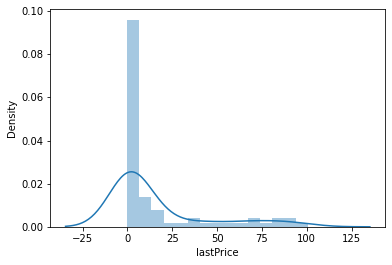

In [ ]:
sns.distplot(prices) #plot distribution of current prices)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


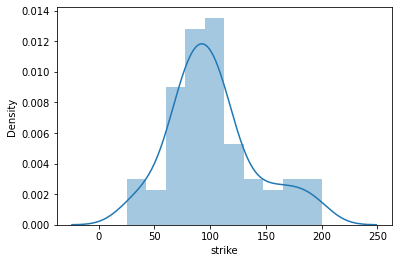

In [ ]:
sns.distplot(strikes)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


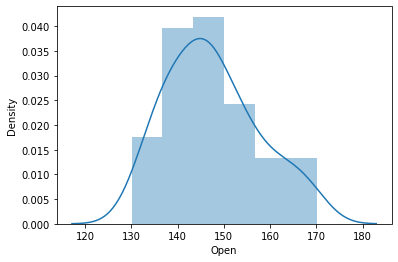

In [ ]:
sns.distplot(stock_data['Open'])

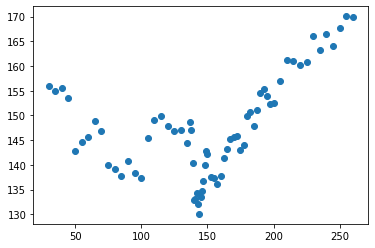

In [ ]:
plt.scatter(strikes,stock_data['Open'])

I believe the chart above matches the theoretical relationship we should expect between strike price and fair price.


# Data prep for deep learning




In [ ]:
#put markers into library
data = {'price': prices,
        'strike': strikes,
        'volume': vols,
        'openInterest': openInt,
        'impliedVolatility':volatils}

# Create DataFrame from library
df = pd.DataFrame(data)

#we want to use all the features to predict price
x = df.drop("price", axis=1) #axis=1 for col, gets rid of "price" col
y = df["price"] # only "price" col data

from sklearn.model_selection import train_test_split #import train test split method from sklearn package (within pandas)

x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=0.2, random_state=0) #RETURNS arrays with desired splitting of data for training and testing

# Train using linear models

In [ ]:
#fit to different linear models
lr = LinearRegression().fit(x_train, y_train) #fits models given the training data, find weights that will fit x to y
la = Lasso().fit(x_train, y_train) #fit with Lasso:linear model that disregards less "important" features
ri = Ridge().fit(x_train, y_train) #fit with Ridge:linear model that "penalizes" less "important" features
en = ElasticNet().fit(x_train, y_train)

# Test using linear models

In [ ]:
#given test inputs, make predictions
lr_pred = lr.predict(x_test)
la_pred = la.predict(x_test)
ri_pred = ri.predict(x_test)
en_pred = en.predict(x_test)

#gives MSE for each model
print("LinearReg mse:"+str(mean_squared_error(y_test, lr_pred)))
print("Lasso mse:"+str(mean_squared_error(y_test, la_pred)))
print("Ridge mse:"+str(mean_squared_error(y_test, ri_pred)))
print("ElNet mse:"+str(mean_squared_error(y_test, en_pred)))

LinearReg mse:40.86461641757067
Lasso mse:25.360413559171654
Ridge mse:18.909878437909285
ElNet mse:139.38575485978296


# Analysis of model performance

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


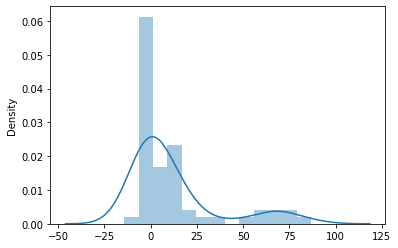

In [ ]:
sns.distplot(ri_pred)

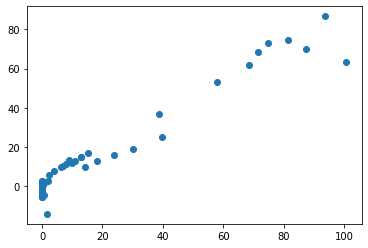

In [ ]:
plt.scatter(y_test, ri_pred)

# Prediction

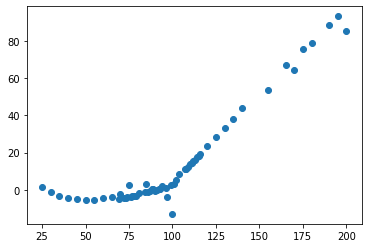

In [ ]:
plt.scatter(x_test['strike'], ri_pred)


In [ ]:
df.loc[(df['strike'] > 90) & (df['strike'] < 105)]

,price,strike,volume,openInterest,impliedVolatility
32,0.09,91.0,1838,2056,0.511724
33,0.13,92.0,2180,3681,0.498052
34,0.17,93.0,2143,2359,0.486333
35,0.23,94.0,1077,2805,0.474615
36,0.32,95.0,7443,18916,0.461919
37,0.45,96.0,3748,4393,0.456548
38,0.64,97.0,9702,2689,0.446783
39,0.87,98.0,5188,3731,0.439459
40,1.15,99.0,4826,7385,0.434576
41,1.56,100.0,24268,12055,0.433599


In [ ]:
ri_pred

array([ 1.41929993e+01,  1.92612467e+01, -1.84335649e+00,  8.55860550e+01,
       -4.48817429e-01,  3.02856641e+00,  7.92623828e+01,  1.60266162e+01,
        6.22827633e-01, -4.65330491e+00,  5.50733154e+00,  2.34431962e+01,
       -1.30275568e+01,  2.31103160e+00,  3.77875027e-01,  6.70945583e+01,
       -1.19032770e+00,  1.13117754e+01,  2.85281525e+01,  1.82884207e+01,
       -5.74045299e+00,  1.22217981e+01,  6.45165583e+01, -5.18238908e+00,
        5.39708401e+01,  1.09639765e+01, -3.44298289e+00,  8.25421204e+00,
        3.82731846e+01, -2.11188247e+00,  3.36395168e-01, -4.43963493e+00,
        4.42827752e+01, -4.87858034e+00, -6.78038434e-01, -3.89739933e+00,
        1.75322965e+01, -1.26658147e+00, -8.34863581e-02,  8.84933738e+01,
       -4.36600094e+00,  3.05913860e+00, -3.23758891e+00,  4.92928059e-01,
        3.34852602e+01,  2.10073181e+00, -3.58114806e+00,  1.27332736e+00,
        9.34447117e+01, -4.18322153e+00, -5.71834075e+00,  1.53238733e+01,
        2.42481161e+00,  